In [1]:
import os
base_path = os.path.join("C:\\","Users","qpatole","Google Drive")

In [16]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
import cv2
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

def fetchResized(filename, x, y):
    image =  cv2.imread(filename)
    return cv2.resize(image ,(int(x),int(y)))
    

In [17]:
target_size=64

In [18]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted","Millifiera")
millifiera = []
for img_path in glob.glob(os.path.join(wings_path,'*.jpg')):
    millifiera.append(fetchResized(img_path, target_size, target_size))


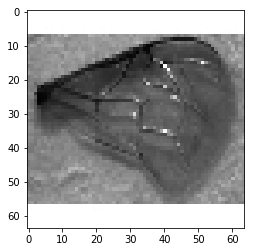

In [19]:
plt.imshow(millifiera[10])

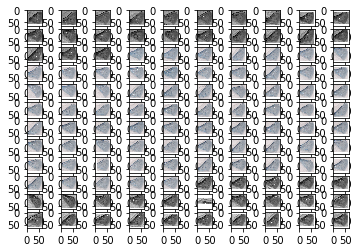

In [20]:
columns = 10
max = len(millifiera)
max = 118
for i, image in enumerate(millifiera):
    plt.subplot(max / columns + 1, columns, i + 1)
    plt.imshow(image)
    if (i > max):
        break


In [21]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted","Carnica")
carnica = []
for img_path in glob.glob(os.path.join(wings_path,'*.jpg')):
    carnica.append(fetchResized(img_path, target_size, target_size))


In [67]:
plt.imshow(carnica[40])

IndexError: list index out of range

In [23]:
print(millifiera[0].shape)
print(len(millifiera))

(64, 64, 3)
726


In [24]:
print(carnica[0].shape[2])
print(len(carnica))

3
20


In [25]:
for image in carnica:
    if image.shape[2] != 3:
        print(image.shape)

In [26]:
millifiera_train_len = int(len(millifiera)*0.8)
carnica_train_len = int(len(carnica)*0.8)
x_train = millifiera[0:millifiera_train_len] + carnica[0:carnica_train_len]
y_train = [0] * millifiera_train_len + [1] * carnica_train_len
print(len(x_train))
print(len(y_train))

millifiera_test_len = len(millifiera) - millifiera_train_len
carnica_test_len = len(carnica) - carnica_train_len
x_test = millifiera[millifiera_train_len:] + carnica[carnica_train_len:]
y_test = [0] * millifiera_test_len + [1] * carnica_test_len
print(len(x_test))
print(len(y_test))


596
596
150
150


In [50]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(80, (3, 3), padding='same', input_shape = (target_size, target_size, 3), activation = 'relu'))
classifier.add(Conv2D(80, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) 
# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) 
# Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) 
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.5)) 
classifier.add(Dense(units = 5, activation = 'softmax'))

In [51]:
# Compiling the CNN
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [52]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 80)        2240      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 80)        57680     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 80)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 80)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 31, 64)        46144     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
__________

In [53]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=3)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [54]:
print(len(x_train))

596


In [55]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "training_set")

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=3)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(wings_path,
                                                 target_size = (target_size,
                                                 target_size),
                                                 batch_size = 16,
                                                 class_mode =
                                                     'categorical')
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set")

test_set = test_datagen.flow_from_directory(wings_path,
                                            target_size = (target_size, target_size),
                                            batch_size = 16,
                                            class_mode =
                                                 'categorical')


Found 3159 images belonging to 5 classes.
Found 321 images belonging to 5 classes.


In [56]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [57]:
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = 100,
                                   epochs = 20,
                                   callbacks=[checkpointer],
                                   validation_data = test_set,
                                   validation_steps = 150)

Epoch 1/20
100/100 [==============================] - 109s 1s/step - loss: 1.6272 - acc: 0.2612 - val_loss: 1.4361 - val_acc: 0.4035

Epoch 00001: val_acc improved from -inf to 0.40349, saving model to best_weights.hdf5
Epoch 2/20
100/100 [==============================] - 109s 1s/step - loss: 1.3013 - acc: 0.4421 - val_loss: 2.3643 - val_acc: 0.5085

Epoch 00002: val_acc improved from 0.40349 to 0.50850, saving model to best_weights.hdf5
Epoch 3/20
100/100 [==============================] - 107s 1s/step - loss: 0.8693 - acc: 0.6544 - val_loss: 1.4938 - val_acc: 0.5129

Epoch 00003: val_acc improved from 0.50850 to 0.51285, saving model to best_weights.hdf5
Epoch 4/20
100/100 [==============================] - 107s 1s/step - loss: 0.7031 - acc: 0.7104 - val_loss: 0.3248 - val_acc: 0.9207

Epoch 00004: val_acc improved from 0.51285 to 0.92070, saving model to best_weights.hdf5
Epoch 5/20
100/100 [==============================] - 104s 1s/step - loss: 0.5532 - acc: 0.7756 - val_loss: 0.2

In [58]:
classifier.load_weights('best_weights.hdf5')

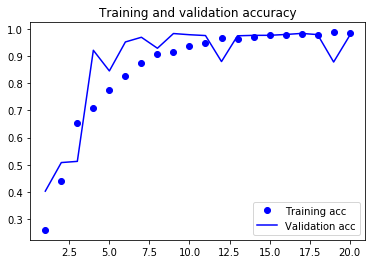

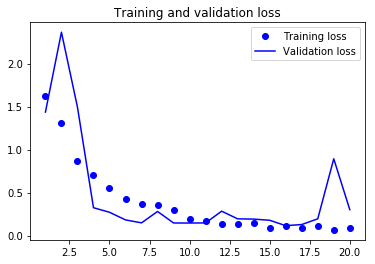

In [59]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

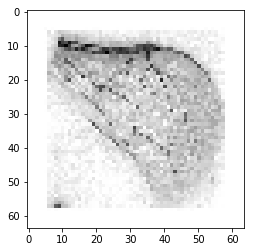

(1, 64, 64, 3)
Predicted class is: [0]


In [60]:
from keras.preprocessing import image
img_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "Carnica","Wassvik-OW-2016-19.jpg")
img = image.load_img(img_path, target_size=(target_size, target_size))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)
# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = classifier.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

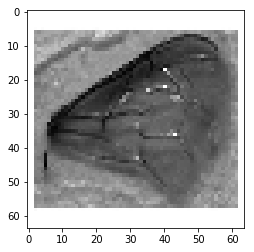

(1, 64, 64, 3)
Predicted class is: [1]


In [61]:
from keras.preprocessing import image
img_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "Millifiera","bee-wing-aby-acb-1717-30.jpg")
img = image.load_img(img_path, target_size=(target_size, target_size))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)
# predicting images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = classifier.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

In [62]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "Carnica")
classes = []

for img_path in glob.glob(os.path.join(wings_path,'*.jpg')):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes.append(classifier.predict_classes(images, batch_size=10)[0])
print(np.histogram(classes,[0,1,2,3,4,5]))   


(array([128,   0,   0,   0,   0], dtype=int64), array([0, 1, 2, 3, 4, 5]))


In [63]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "Millifiera")
classes = []
for img_path in glob.glob(os.path.join(wings_path,'*.jpg')):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes.append(classifier.predict_classes(images, batch_size=10)[0])
print(np.histogram(classes,[0,1,2,3,4,5]))   



(array([  6, 121,   0,   3,   0], dtype=int64), array([0, 1, 2, 3, 4, 5]))


In [64]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "circles")
classes = []

for img_path in glob.glob(os.path.join(wings_path,'*.png')):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes.append(classifier.predict_classes(images, batch_size=10)[0])
print(np.histogram(classes,[0,1,2,3,4,5]))   


(array([ 0,  0, 19,  2,  0], dtype=int64), array([0, 1, 2, 3, 4, 5]))


In [65]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "triangles")
classes = []

for img_path in glob.glob(os.path.join(wings_path,'*.png')):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes.append(classifier.predict_classes(images, batch_size=10)[0])
print(np.histogram(classes,[0,1,2,3,4,5]))   


(array([ 0,  0,  3,  1, 17], dtype=int64), array([0, 1, 2, 3, 4, 5]))


In [66]:
wings_path = os.path.join(base_path, "Bee","WingDataFiles","bee","wings","extracted", "test_set", "squares")
classes = []

for img_path in glob.glob(os.path.join(wings_path,'*.png')):
    img = image.load_img(img_path, target_size=(target_size, target_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes.append(classifier.predict_classes(images, batch_size=10)[0])
print(np.histogram(classes,[0,1,2,3,4,5]))   

(array([ 0,  0,  0, 21,  0], dtype=int64), array([0, 1, 2, 3, 4, 5]))
